In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dfs = []
for name in ["results_mixed_complexity_0.csv",
             "results_mixed_complexity_1.csv",
             "results_mixed_new_0.csv",
             "results_mixed_new_1.csv", 
             "results_mixed_0_2.csv", 
             "results_mixed_1_3.csv",
             "results_mixed_infidelity.csv",
             "results_mixed_cams_0.csv",
             "results_mixed_cams_1.csv",
             "results_mixed_cams_2.csv",
             "results_mixed_cams_3.csv",
             "results_mixed_cams_others_bilinear_0.csv",
             "results_mixed_cams_others_bilinear_1.csv",
             "results_mixed_cams_others_bilinear_2.csv",]:
    df = pd.read_csv(name)
    # Replace all the Nans with 0s
    df = df.fillna(0)
    dfs.append(df)

# Concatenate the two dataframes
df = pd.concat(dfs, ignore_index=True)

df = df[df["Dataset"] == "Imagenettewoof"]

# df = df[df["Predicted Label"] != df["Label"]]
# df = df[df["Label"] >= 10]

# Remove all the rows where attribution is GradCAMPlusPlus and metric is coherency
print(df.shape)
df = df[~((df["Attribution Method"] == "GradCAMPlusPlus") & (df["Metric"] == "coherency"))]
print(df.shape)

coherency_df = pd.read_csv("results_gradcam_coherency.csv")
coherency_df = coherency_df.fillna(0)

# Concat the two dataframes
df = pd.concat([df, coherency_df], ignore_index=True)
print(df.shape)

# If mixing method is '0', convert it to number
df["Mixing Method"] = df["Mixing Method"].replace("0", 0)

(303821, 11)
(287821, 11)
(303821, 11)


In [185]:
df.columns

Index(['Image Index', 'Label', 'Predicted Label', 'Model', 'Dataset',
       'Attribution Method', 'Layer', 'Metric', 'Upscale Method',
       'Mixing Method', 'Value'],
      dtype='object')

In [186]:
df[(df["Image Index"] == 778) & (df["Attribution Method"] == "ScoreCAM") & (df["Layer"] == "features.20")]

,Image Index,Label,Predicted Label,Model,Dataset,Attribution Method,Layer,Metric,Upscale Method,Mixing Method,Value
133412,778,12,12,VGG11,Imagenettewoof,ScoreCAM,features.20,road_combined,ERFUpsamplingFast,0,0.363969
133413,778,12,12,VGG11,Imagenettewoof,ScoreCAM,features.20,road_combined,ERFUpsamplingFast,MultiplierMix,0.364048
133420,778,12,12,VGG11,Imagenettewoof,ScoreCAM,features.20,road_combined,bilinearUpsampling,0,0.351883
133421,778,12,12,VGG11,Imagenettewoof,ScoreCAM,features.20,road_combined,bilinearUpsampling,MultiplierMix,0.351793
255956,778,12,12,VGG11,Imagenettewoof,ScoreCAM,features.20,deletion_curve_AUC,bilinearUpsampling,0,0.029730
255957,778,12,12,VGG11,Imagenettewoof,ScoreCAM,features.20,deletion_curve_AUC,bilinearUpsampling,MultiplierMix,0.029730
255958,778,12,12,VGG11,Imagenettewoof,ScoreCAM,features.20,insertion_curve_AUC,bilinearUpsampling,0,0.667521
255959,778,12,12,VGG11,Imagenettewoof,ScoreCAM,features.20,insertion_curve_AUC,bilinearUpsampling,MultiplierMix,0.667521
255960,778,12,12,VGG11,Imagenettewoof,ScoreCAM,features.20,infidelity,bilinearUpsampling,0,0.050206
255961,778,12,12,VGG11,Imagenettewoof,ScoreCAM,features.20,infidelity,bilinearUpsampling,MultiplierMix,0.072364


In [187]:
# Pivot the data to get 'average_drop' and 'insertion_curve_AUC' side-by-side
pivoted = df.pivot_table(
    index=['Image Index', 'Label', 'Predicted Label', 'Model', 'Dataset',
           'Attribution Method', 'Layer', 'Upscale Method', 'Mixing Method'],
    columns='Metric',
    values='Value',
    aggfunc='mean'  # or 'mean' if there are duplicates and you want the mean
).reset_index()

pivoted["complexity"] = pivoted["complexity"].astype(float) / 224
pivoted["average_drop"] = pivoted["average_drop"].astype(float) / 100

def compute_ADCC(row):
    if row['coherency'] > 0 and row['complexity'] < 1 and row['average_drop'] < 1:
        return 3 * ((1 / row['coherency']) + (1 / (1 - row['complexity'])) + (1 / (1 - row['average_drop']))) ** -1
    else:
        return None
    
def compute_ARCC(row):
    if row['coherency'] > 0 and row['complexity'] < 1 and row['road_combined'] < 1:
        return 3 * ((1 / row['coherency']) + (1 / (1 - row['complexity'])) + (1 / ((1 + row['road_combined'])/2))) ** -1
    else:
        return None
    
pivoted['ADCC'] = pivoted.apply(compute_ADCC, axis=1)
# Calculate the harmonic mean
# pivoted['ADCC'] = pivoted.apply(
#     lambda row: 3*((1/row['coherency']) + (1 / (1 - row["complexity"])) + (1 / (1 - row['average_drop'])))**-1
#     if (row['coherency']>0 and row["complexity"] < 1 and row["average_drop"] < 1 else None,
#     axis=1
# )
pivoted['ARCC'] = pivoted.apply(compute_ARCC, axis=1)

# pivoted["ARCC"] = pivoted.apply(
#     lambda row: 3*((1/row['coherency']) + (1 / (1 - row["complexity"])) + (1 / (1 - row['road_combined'])))**-1,
#     # if pd.notnull(row['average_drop']) and pd.notnull(row['insertion_curve_AUC']) else None,
#     axis=1
# )

In [188]:
# First, melt back the metric columns (including your new ADCC one)
melted = pivoted.melt(
    id_vars=['Image Index', 'Label', 'Predicted Label', 'Model', 'Dataset',
             'Attribution Method', 'Layer', 'Upscale Method', 'Mixing Method'],
    value_vars=['average_drop', 'insertion_curve_AUC', 'deletion_curve_AUC', 'coherency', 'complexity', 'ADCC','road_combined', 'infidelity', "ARCC"],
    var_name='Metric',
    value_name='Value'
)

# Optional: sort or reset index if needed
melted = melted.sort_values(by=['Image Index', 'Metric']).reset_index(drop=True)

df = melted.copy()

In [189]:
df[df["Metric"] == "ARCC"]

,Image Index,Label,Predicted Label,Model,Dataset,Attribution Method,Layer,Upscale Method,Mixing Method,Metric,Value
64,0,2,2,VGG11,Imagenettewoof,EigenCAM,features.10,ERFUpsamplingFast,0,ARCC,NaN
65,0,2,2,VGG11,Imagenettewoof,EigenCAM,features.10,ERFUpsamplingFast,MultiplierMix,ARCC,NaN
66,0,2,2,VGG11,Imagenettewoof,EigenCAM,features.10,bilinearUpsampling,0,ARCC,0.576566
67,0,2,2,VGG11,Imagenettewoof,EigenCAM,features.10,bilinearUpsampling,MultiplierMix,ARCC,0.653099
68,0,2,2,VGG11,Imagenettewoof,EigenCAM,features.15,ERFUpsamplingFast,0,ARCC,NaN
...,...,...,...,...,...,...,...,...,...,...,...
575511,999,19,19,VGG11,Imagenettewoof,ScoreCAM,features.20,bilinearUpsampling,MultiplierMix,ARCC,0.771308
575512,999,19,19,VGG11,Imagenettewoof,ScoreCAM,features.5,ERFUpsamplingFast,0,ARCC,NaN
575513,999,19,19,VGG11,Imagenettewoof,ScoreCAM,features.5,ERFUpsamplingFast,MultiplierMix,ARCC,NaN
575514,999,19,19,VGG11,Imagenettewoof,ScoreCAM,features.5,bilinearUpsampling,0,ARCC,NaN


In [190]:
methods = df["Attribution Method"].unique()
layers = df["Layer"].unique()
metrics = df["Metric"].unique()
upscale_methods = df["Upscale Method"].unique()
mixing_methods = df["Mixing Method"].unique()

In [191]:
print("Methods:", methods)
print("Layers:", layers)
print("Metrics:", metrics)
print("Upscale Methods:", upscale_methods)
print("Mixing Methods:", mixing_methods)

Methods: ['EigenCAM' 'GradCAMPlusPlus' 'LayerCAM' 'ScoreCAM']
Layers: ['features.10' 'features.15' 'features.20' 'features.5']
Metrics: ['ADCC' 'ARCC' 'average_drop' 'coherency' 'complexity'
 'deletion_curve_AUC' 'infidelity' 'insertion_curve_AUC' 'road_combined']
Upscale Methods: ['ERFUpsamplingFast' 'bilinearUpsampling']
Mixing Methods: [0 'MultiplierMix']


In [158]:
df[df["Attribution Method"] == "GradCAMPlusPlus"]["Metric"].unique()

array(['ADCC', 'ARCC', 'average_drop', 'coherency', 'complexity',
       'deletion_curve_AUC', 'infidelity', 'insertion_curve_AUC',
       'road_combined'], dtype=object)

In [8]:
import sys
sys.path.append('../')

from models import vgg11_Imagenettewoof, vgg_preprocess
import torch
from data import imagenettewoof
model = vgg11_Imagenettewoof()
# Load weights
model.load_state_dict(torch.load("VGG11_Imagenettewoof.pt", map_location='cpu'))

# test_data = imagenettewoof(root="../data", split="test", size="320px", download=False, transform=vgg_preprocess)

layer_types = {}
types = []
for i, layer in enumerate(layers):
    layer_type = model.features[int(layer.split(".")[-1])].__class__.__name__
    layer_types[layer] = layer_type
    if layer_type not in types:
        types.append(layer_type)

print(types)
print(layer_types)

['MaxPool2d']
{'features.10': 'MaxPool2d', 'features.15': 'MaxPool2d', 'features.20': 'MaxPool2d', 'features.5': 'MaxPool2d'}


In [159]:
df[(df["Attribution Method"] == "GradCAMPlusPlus") & (df["Metric"] == "coherency") & (df["Mixing Method"] == 0)]

,Image Index,Label,Predicted Label,Model,Dataset,Attribution Method,Layer,Upscale Method,Mixing Method,Metric,Value
208,0,2,2,VGG11,Imagenettewoof,GradCAMPlusPlus,features.10,ERFUpsamplingFast,0,coherency,0.934705
210,0,2,2,VGG11,Imagenettewoof,GradCAMPlusPlus,features.10,bilinearUpsampling,0,coherency,0.952285
212,0,2,2,VGG11,Imagenettewoof,GradCAMPlusPlus,features.15,ERFUpsamplingFast,0,coherency,0.832055
214,0,2,2,VGG11,Imagenettewoof,GradCAMPlusPlus,features.15,bilinearUpsampling,0,coherency,0.944765
216,0,2,2,VGG11,Imagenettewoof,GradCAMPlusPlus,features.20,ERFUpsamplingFast,0,coherency,0.842882
...,...,...,...,...,...,...,...,...,...,...,...
575593,999,19,19,VGG11,Imagenettewoof,GradCAMPlusPlus,features.15,bilinearUpsampling,0,coherency,0.950916
575595,999,19,19,VGG11,Imagenettewoof,GradCAMPlusPlus,features.20,ERFUpsamplingFast,0,coherency,0.977817
575597,999,19,19,VGG11,Imagenettewoof,GradCAMPlusPlus,features.20,bilinearUpsampling,0,coherency,0.985197
575599,999,19,19,VGG11,Imagenettewoof,GradCAMPlusPlus,features.5,ERFUpsamplingFast,0,coherency,0.964420


ERFUpsamplingFast
        Image Index  Label  Predicted Label  Model         Dataset  \
512               0      2                2  VGG11  Imagenettewoof   
516               0      2                2  VGG11  Imagenettewoof   
520               0      2                2  VGG11  Imagenettewoof   
524               0      2                2  VGG11  Imagenettewoof   
1088              1      6                6  VGG11  Imagenettewoof   
...             ...    ...              ...    ...             ...   
575354          998     18               18  VGG11  Imagenettewoof   
575846          999     19               19  VGG11  Imagenettewoof   
575850          999     19               19  VGG11  Imagenettewoof   
575854          999     19               19  VGG11  Imagenettewoof   
575858          999     19               19  VGG11  Imagenettewoof   

       Attribution Method        Layer     Upscale Method Mixing Method  \
512              EigenCAM  features.10  ERFUpsamplingFast         

<Figure size 640x480 with 0 Axes>

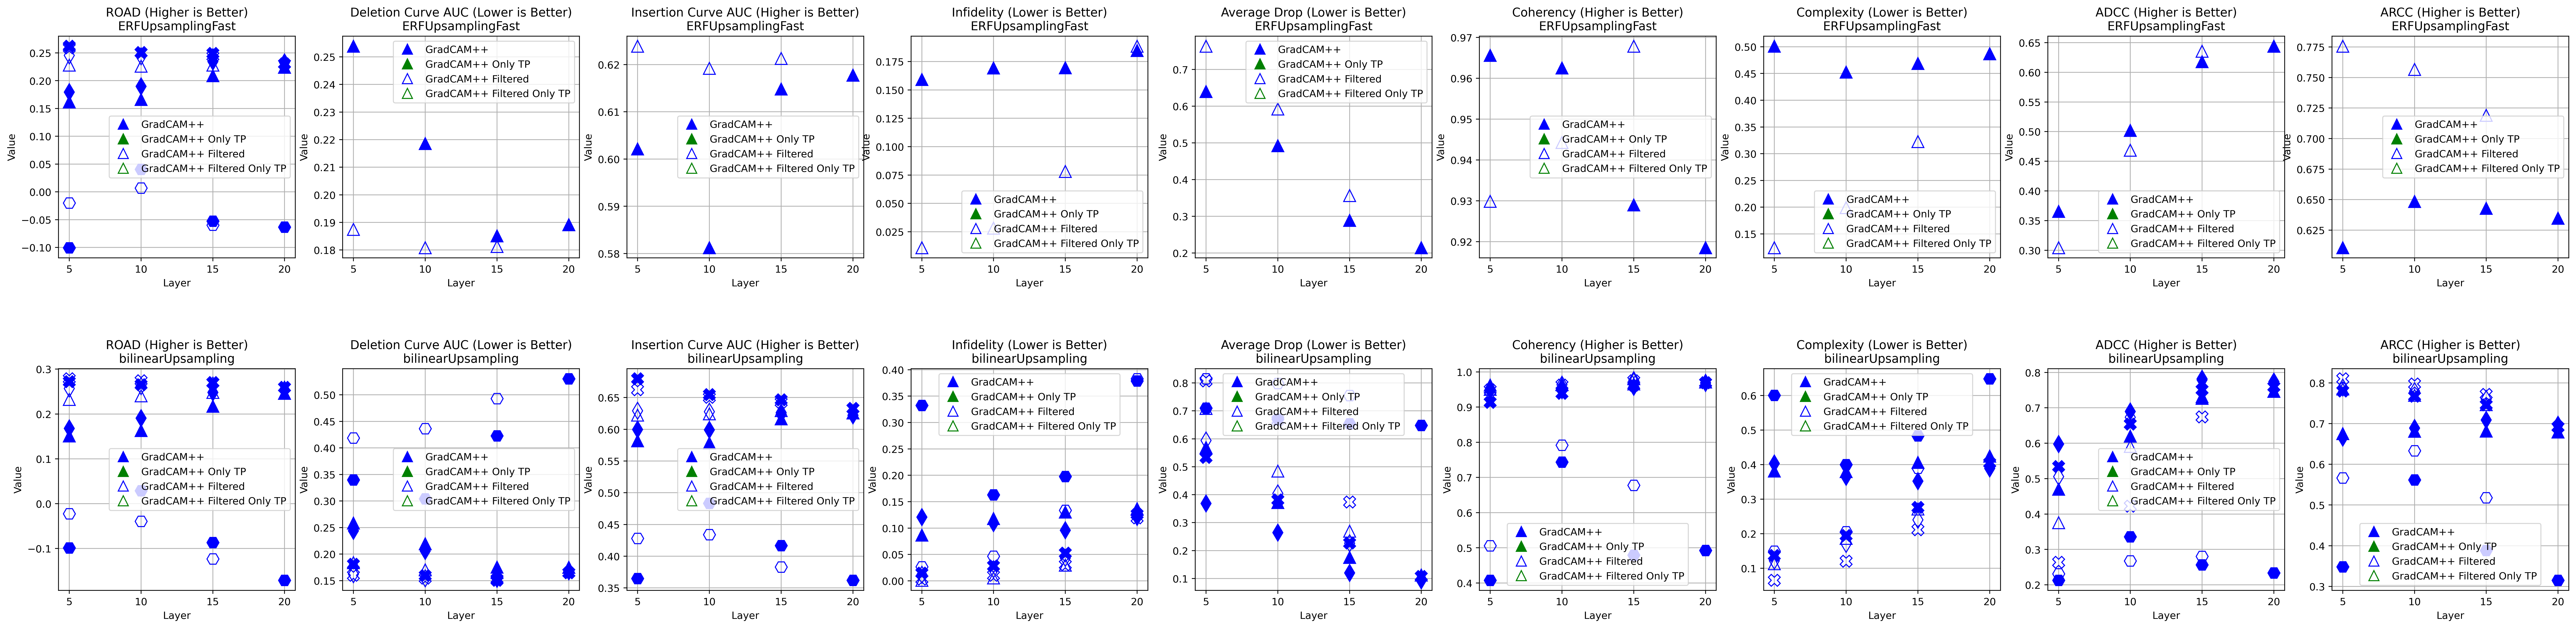

In [192]:
import matplotlib.lines as mlines


color_for_layers = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# shape_for_upscale = {"ERFUpsampling": "P","SimpleUpsampling": "D"}  # Define shape mapping
shape_for_methods = {"GradCAMPlusPlus": "^", "EigenCAM": "H", "LayerCAM": "X", "ScoreCAM": "d"}  # Define shape mapping

method_names = {"GradCAMPlusPlus": r"GradCAM++ NOT Filtered", "DeepLiftShap8": "DeepLiftShap Bilinear Upsampling"}  # Define shape mapping
# upscale_names = {"ERFUpsampling": "ERF Upsampling", "SimpleUpsampling": "Bilinear Upsampling"}  # Define shape mapping
titles = {
    "sensitivity": "Sensitivity (Lower is Better)",
    "infidelity": "Infidelity (Lower is Better)",
    "road_combined": "ROAD (Higher is Better)",
    "ADCC": "ADCC (Higher is Better)",
    "ARCC": "ARCC (Higher is Better)",
    "average_drop": "Average Drop (Lower is Better)",
    "coherency": "Coherency (Higher is Better)",
    "complexity": "Complexity (Lower is Better)",
    "deletion_curve_AUC": "Deletion Curve AUC (Lower is Better)",
    "insertion_curve_AUC": "Insertion Curve AUC (Higher is Better)",
}

# fig.text(0.05, 0.75, 'GradCAM++', ha='center', va='center', fontsize=14) # , fontweight='bold')
# fig.text(0.05, 0.25, 'DeepLiftShap', ha='center', va='center', fontsize=14) # , fontweight='bold')

# plt.suptitle('Infidelity comparison between Filtered and NOT Filtered', fontsize=16)
plt.tight_layout()

metrics = ['road_combined',
           'deletion_curve_AUC',
           'insertion_curve_AUC',
           'infidelity',
           'average_drop',
           'coherency',
           'complexity',
           'ADCC',
           "ARCC"]

# metrics = ["road_combined"]

fig = plt.figure(figsize=(5*len(metrics),10), dpi=400)

for metric_index, metric in enumerate(metrics):
    df_metric = df[df["Metric"] == metric]
    # plt.subplot(3, 2,)
    for index, upscale in enumerate(upscale_methods):
        print(upscale)
        plt.subplot(2, len(metrics), index * len(metrics) + metric_index + 1)
        plt.title(titles[metric] + "\n" + upscale)
        for layer_type in types:
            for mix in mixing_methods:
                for j, attr_method in enumerate(methods):
                    df_correct = df_metric[df_metric["Label"] == df_metric["Predicted Label"]]
                    for df_index, grouped in enumerate([df_metric]):
                        res = grouped[(grouped["Upscale Method"] == upscale) &
                                (grouped["Attribution Method"] == attr_method) & 
                                (grouped["Mixing Method"] == mix)]
                        
                        print(res)
                        res = res.groupby("Layer").agg({"Value": ["mean","std","count"]}).reset_index()
                        res["Layer"] = res["Layer"].apply(lambda x: int(x.split(".")[-1]))
                    
                        if mix == "MultiplierMix":
                            # print("SimpleUpsampling")
                            plt.plot(res["Layer"], res["Value","mean"],shape_for_methods[attr_method],markerfacecolor= 'none', color=color_for_layers[df_index], markersize=12)
                            # plt.errorbar(res["Layer"], res["Value","mean"], yerr=1.96 * res["Value","std"] / res["Value","count"], fmt='o', color=color_for_layers[types.index(layer_type)], markersize=2, capsize=2)
                        else:
                            plt.plot(res["Layer"], res["Value","mean"],shape_for_methods[attr_method], color=color_for_layers[df_index], markersize=12)
                            # plt.errorbar(res["Layer"], res["Value","mean"], yerr=1.96 * res["Value","std"] / res["Value","count"], fmt='o', color=color_for_layers[types.index(layer_type)], markersize=2, capsize=2)
                            # print("ERFUpsampling")

                        plt.xlabel("Layer")
                        plt.ylabel("Value")
                        # Log scale for y
                        if metric == "sensitivity":
                            plt.yscale("log")

                        # plt.ylim([0.1, 0.3])
                        # if metric == "average_drop":
                            # plt.ylim([8, 80])
                        # elif metric == "insertion_curve_AUC":
                        #     plt.ylim([0.65, 0.71])
                        # elif metric == "deletion_curve_AUC":
                        #     plt.ylim([0.25, 0.36])
                        plt.grid(True)


        # Create color legend (Layer Types)
        # color_legend = [mlines.Line2D([], [], color=color, marker='s', linestyle='None', markersize=10, label=layer) 
        #                 for color, layer in zip(color_for_layers, types)]
        color_legend = []

        # Create shape legend (Methods)
        shape_legend = [mlines.Line2D([], [], color='blue', marker='^', linestyle='None', markersize=10, label="GradCAM++"),
                        mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label="GradCAM++ Only TP") 
                        ]
        
        upscale_legend = [mlines.Line2D([], [], color='blue', marker='^', linestyle='None', markersize=10, label="GradCAM++ Filtered", markerfacecolor= 'none'),
                          mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label="GradCAM++ Filtered Only TP", markerfacecolor= 'none'),]
        
        plt.xticks([5,10,15,20])
        plt.legend(handles=color_legend + shape_legend + upscale_legend)

plt.subplots_adjust(hspace=0.5)
plt.savefig('results filter all.pdf', dpi=400, bbox_inches='tight')


       Image Index  Label  Predicted Label  Model         Dataset  \
0                0      2                2  VGG11  Imagenettewoof   
1                0      2                2  VGG11  Imagenettewoof   
2                0      2                2  VGG11  Imagenettewoof   
3                0      2                2  VGG11  Imagenettewoof   
4                0      2                2  VGG11  Imagenettewoof   
...            ...    ...              ...    ...             ...   
31990          999     19               19  VGG11  Imagenettewoof   
31991          999     19               19  VGG11  Imagenettewoof   
31992          999     19               19  VGG11  Imagenettewoof   
31993          999     19               19  VGG11  Imagenettewoof   
31994          999     19               19  VGG11  Imagenettewoof   

      Attribution Method        Layer      Upscale Method         Metric  \
0               EigenCAM  features.10   ERFUpsamplingFast  road_combined   
1               Eig

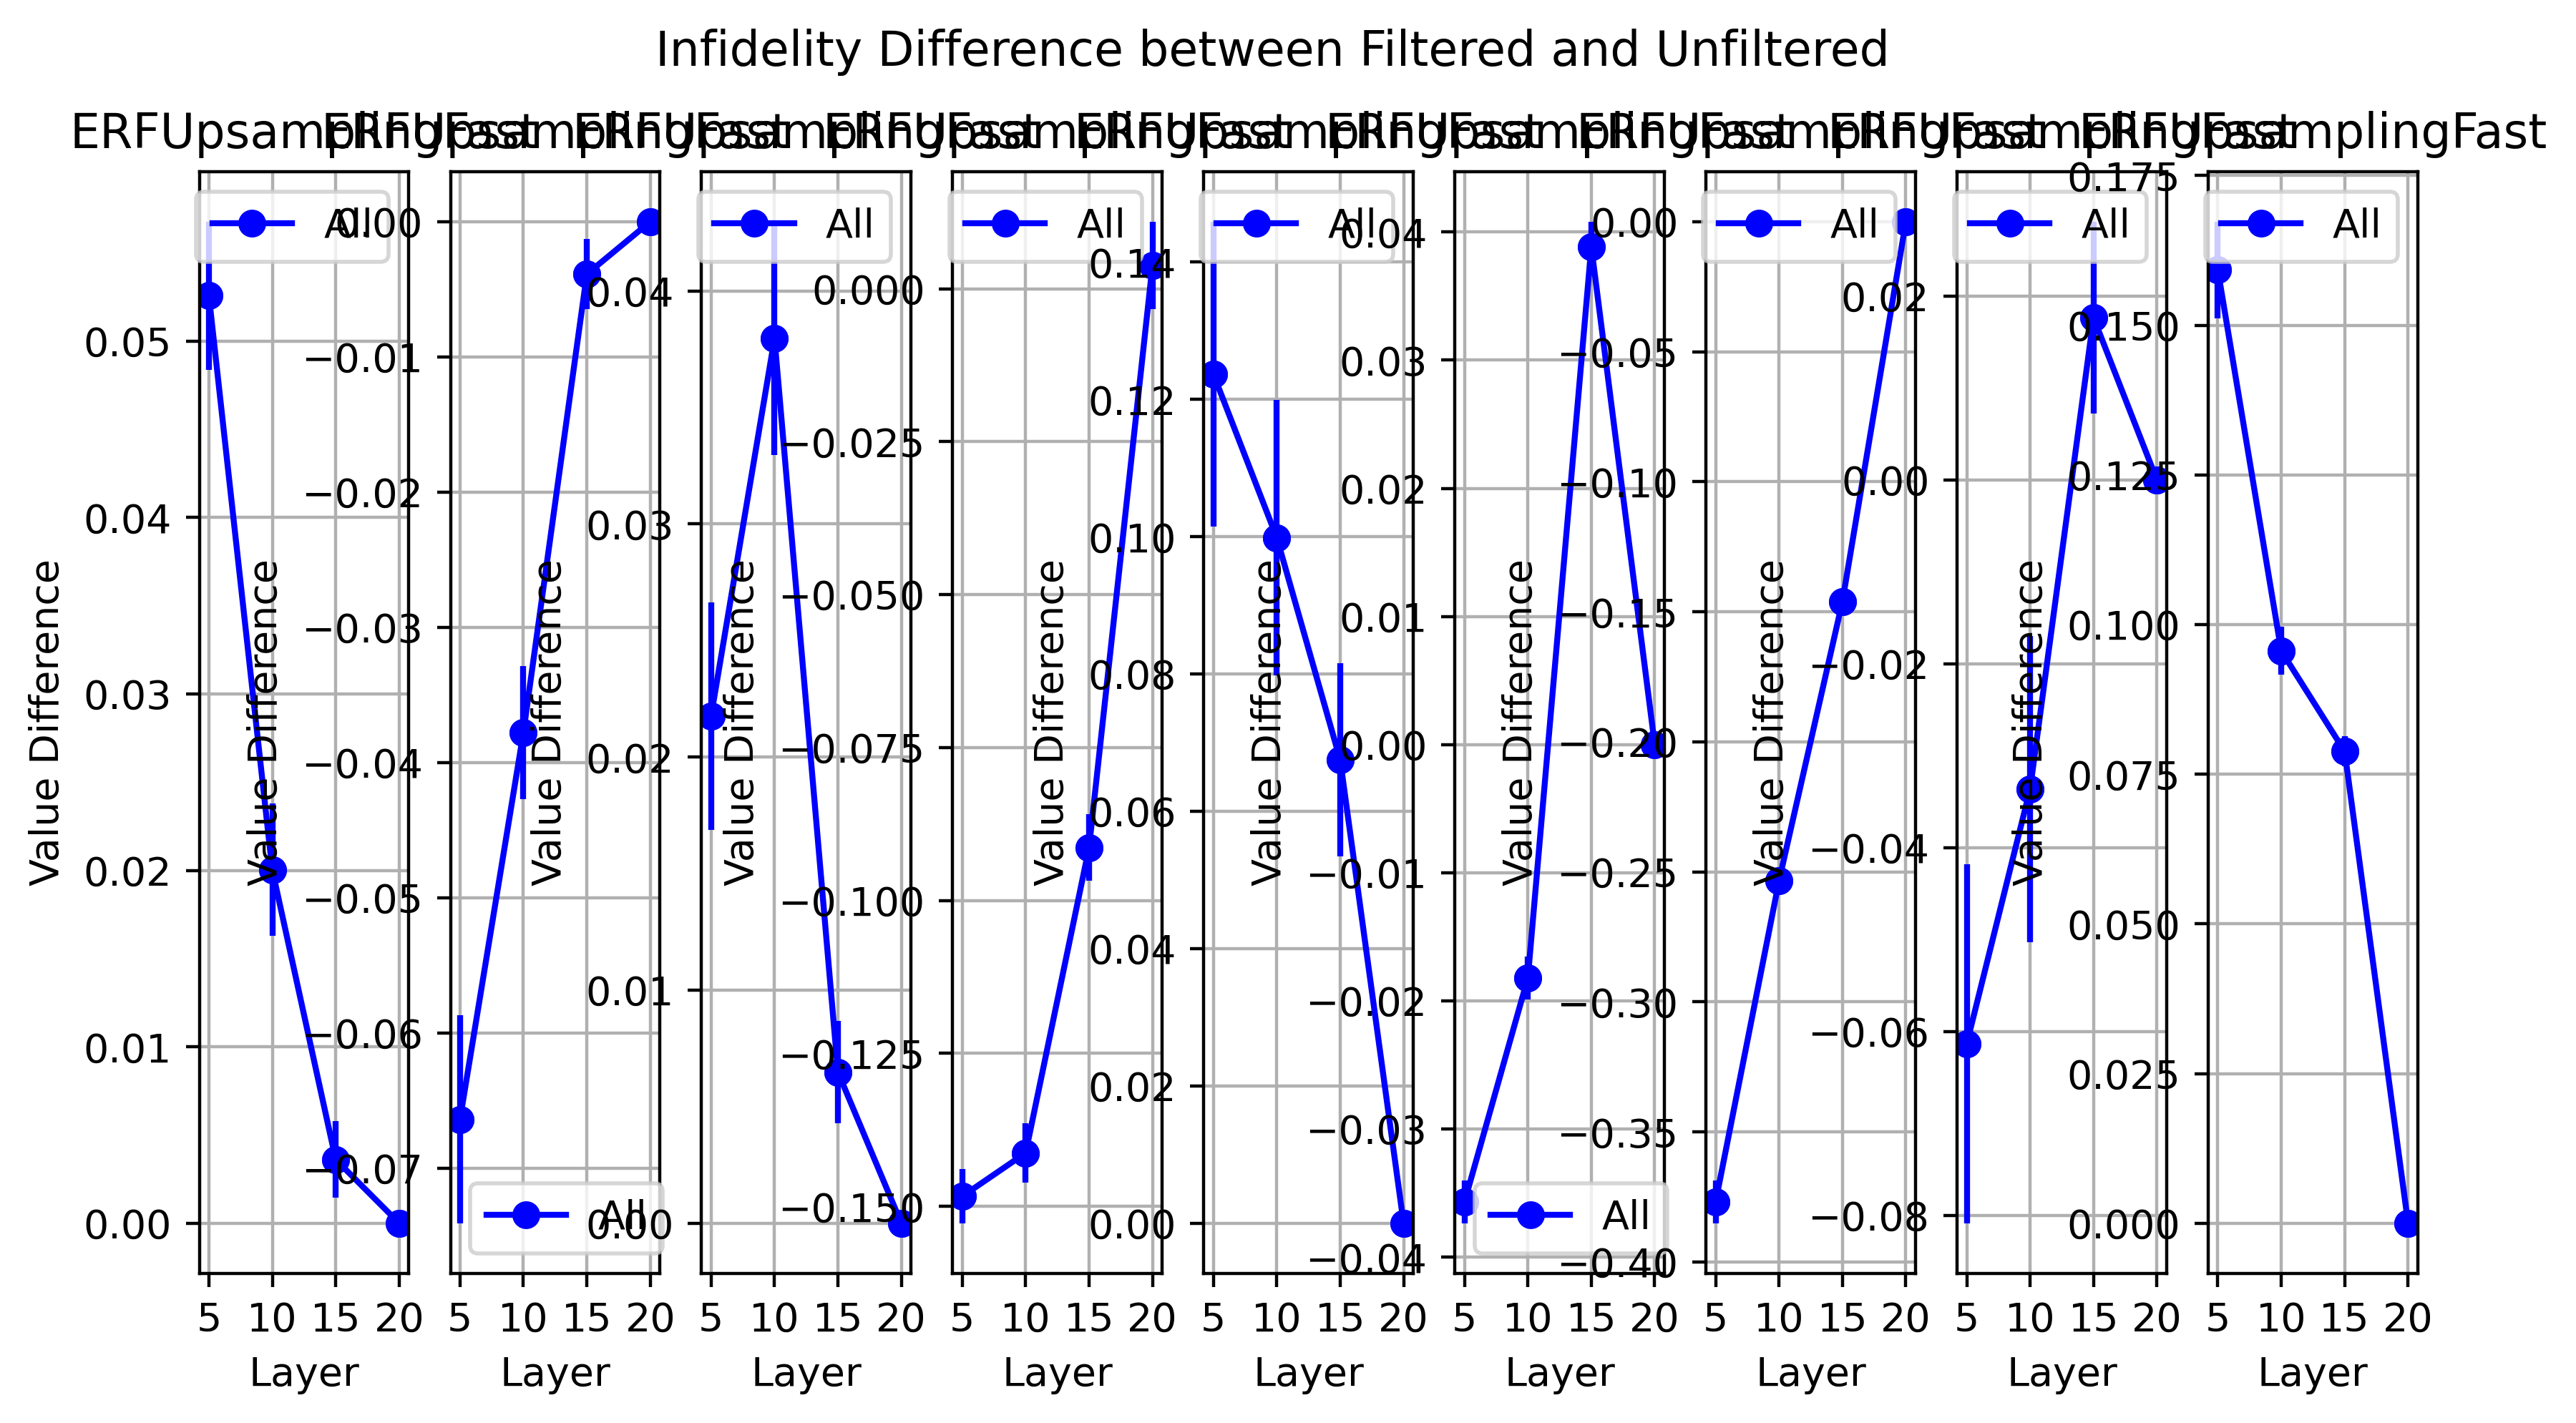

In [163]:
# Plot the grouped data showing also the 95% confidence interval
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import numpy as np


# Function to calculate the difference in 'Value' for each group
def calculate_difference(group):
    if len(group) == 2:
        # Assuming there are exactly two rows in each group with different 'Mixing Method'
        diff = group['Value'].diff().iloc[1]
        return pd.Series([diff], index=['Value Difference'])
    else:
        return pd.Series([None], index=['Value Difference'])


# Apply the function to each group and reset the index
# display(grouped)

plt.figure(figsize=(10,5), dpi=400)
plt.suptitle("Infidelity Difference between Filtered and Unfiltered")
# plt.xlabel("Layer")
# plt.ylabel("Value Difference")
# plt.xticks([5,10,15,20])
# plt.ylim([-0.1, 0.4])
# plt.grid(True)
# Plot data

for index, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), index + 1)
    plt.title(titles[metric])
    df_metric = df[df["Metric"] == metric]
    grouped = df_metric.groupby([col for col in df_metric.columns if col not in ['Mixing Method', 'Value']])

    # df_correct = df[df["Predicted Label"] == df["Label"]]
    # grouped_correct = df_correct.groupby([col for col in df_correct.columns if col not in ['Mixing Method', 'Value']])

    # df_wrong = df[df["Predicted Label"] != df["Label"]]
    # grouped_wrong = df_wrong.groupby([col for col in df_wrong.columns if col not in ['Mixing Method', 'Value']])

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    labels = ['All', 'Correctly Classified', 'Wrongly Classified']

    for index, upscale in enumerate(upscale_methods[:1]):
        # plt.subplot(1, 2, index + 1)
        plt.title(upscale)
        plt.grid(True)
        plt.xlabel("Layer")
        plt.ylabel("Value Difference")
        # plt.ylim([-0.01, 0.12])
        plt.xticks([5,10,15,20])
        
        grouped = grouped.apply(calculate_difference).reset_index()
        print(grouped)
        grouped = grouped[grouped["Upscale Method"] == upscale]        
        grouped = grouped.groupby(["Layer"]).agg({"Value Difference": ["mean","std", "count"]}).reset_index()
        grouped["Layer"] = grouped["Layer"].apply(lambda x: int(x.split(".")[-1]))
        grouped = grouped.sort_values(by="Layer")
        plt.plot(grouped["Layer"], grouped['Value Difference']['mean'], marker='o', label=labels[index], color=colors[index])
        for i, row in grouped.iterrows():
            layer = int(row['Layer'].values[0])
            mean_diff = row['Value Difference']['mean']
            std_diff = 1.96*row['Value Difference']['std'] / np.sqrt(row['Value Difference']['count'])

            # Plot the mean difference with error bars
            plt.errorbar(layer, mean_diff, yerr=std_diff, fmt='o', color=colors[index])

        plt.legend()

# plt.savefig('results mixed difference infidelity.pdf', dpi=400, bbox_inches='tight')

C:\Users\Luca\AppData\Local\Temp\ipykernel_14780\1514218077.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_values["Layer"] = filtered_values["Layer"].apply(lambda x: int(x.split(".")[-1]))
C:\Users\Luca\AppData\Local\Temp\ipykernel_14780\1514218077.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_values["Layer"] = filtered_values["Layer"].apply(lambda x: int(x.split(".")[-1]))


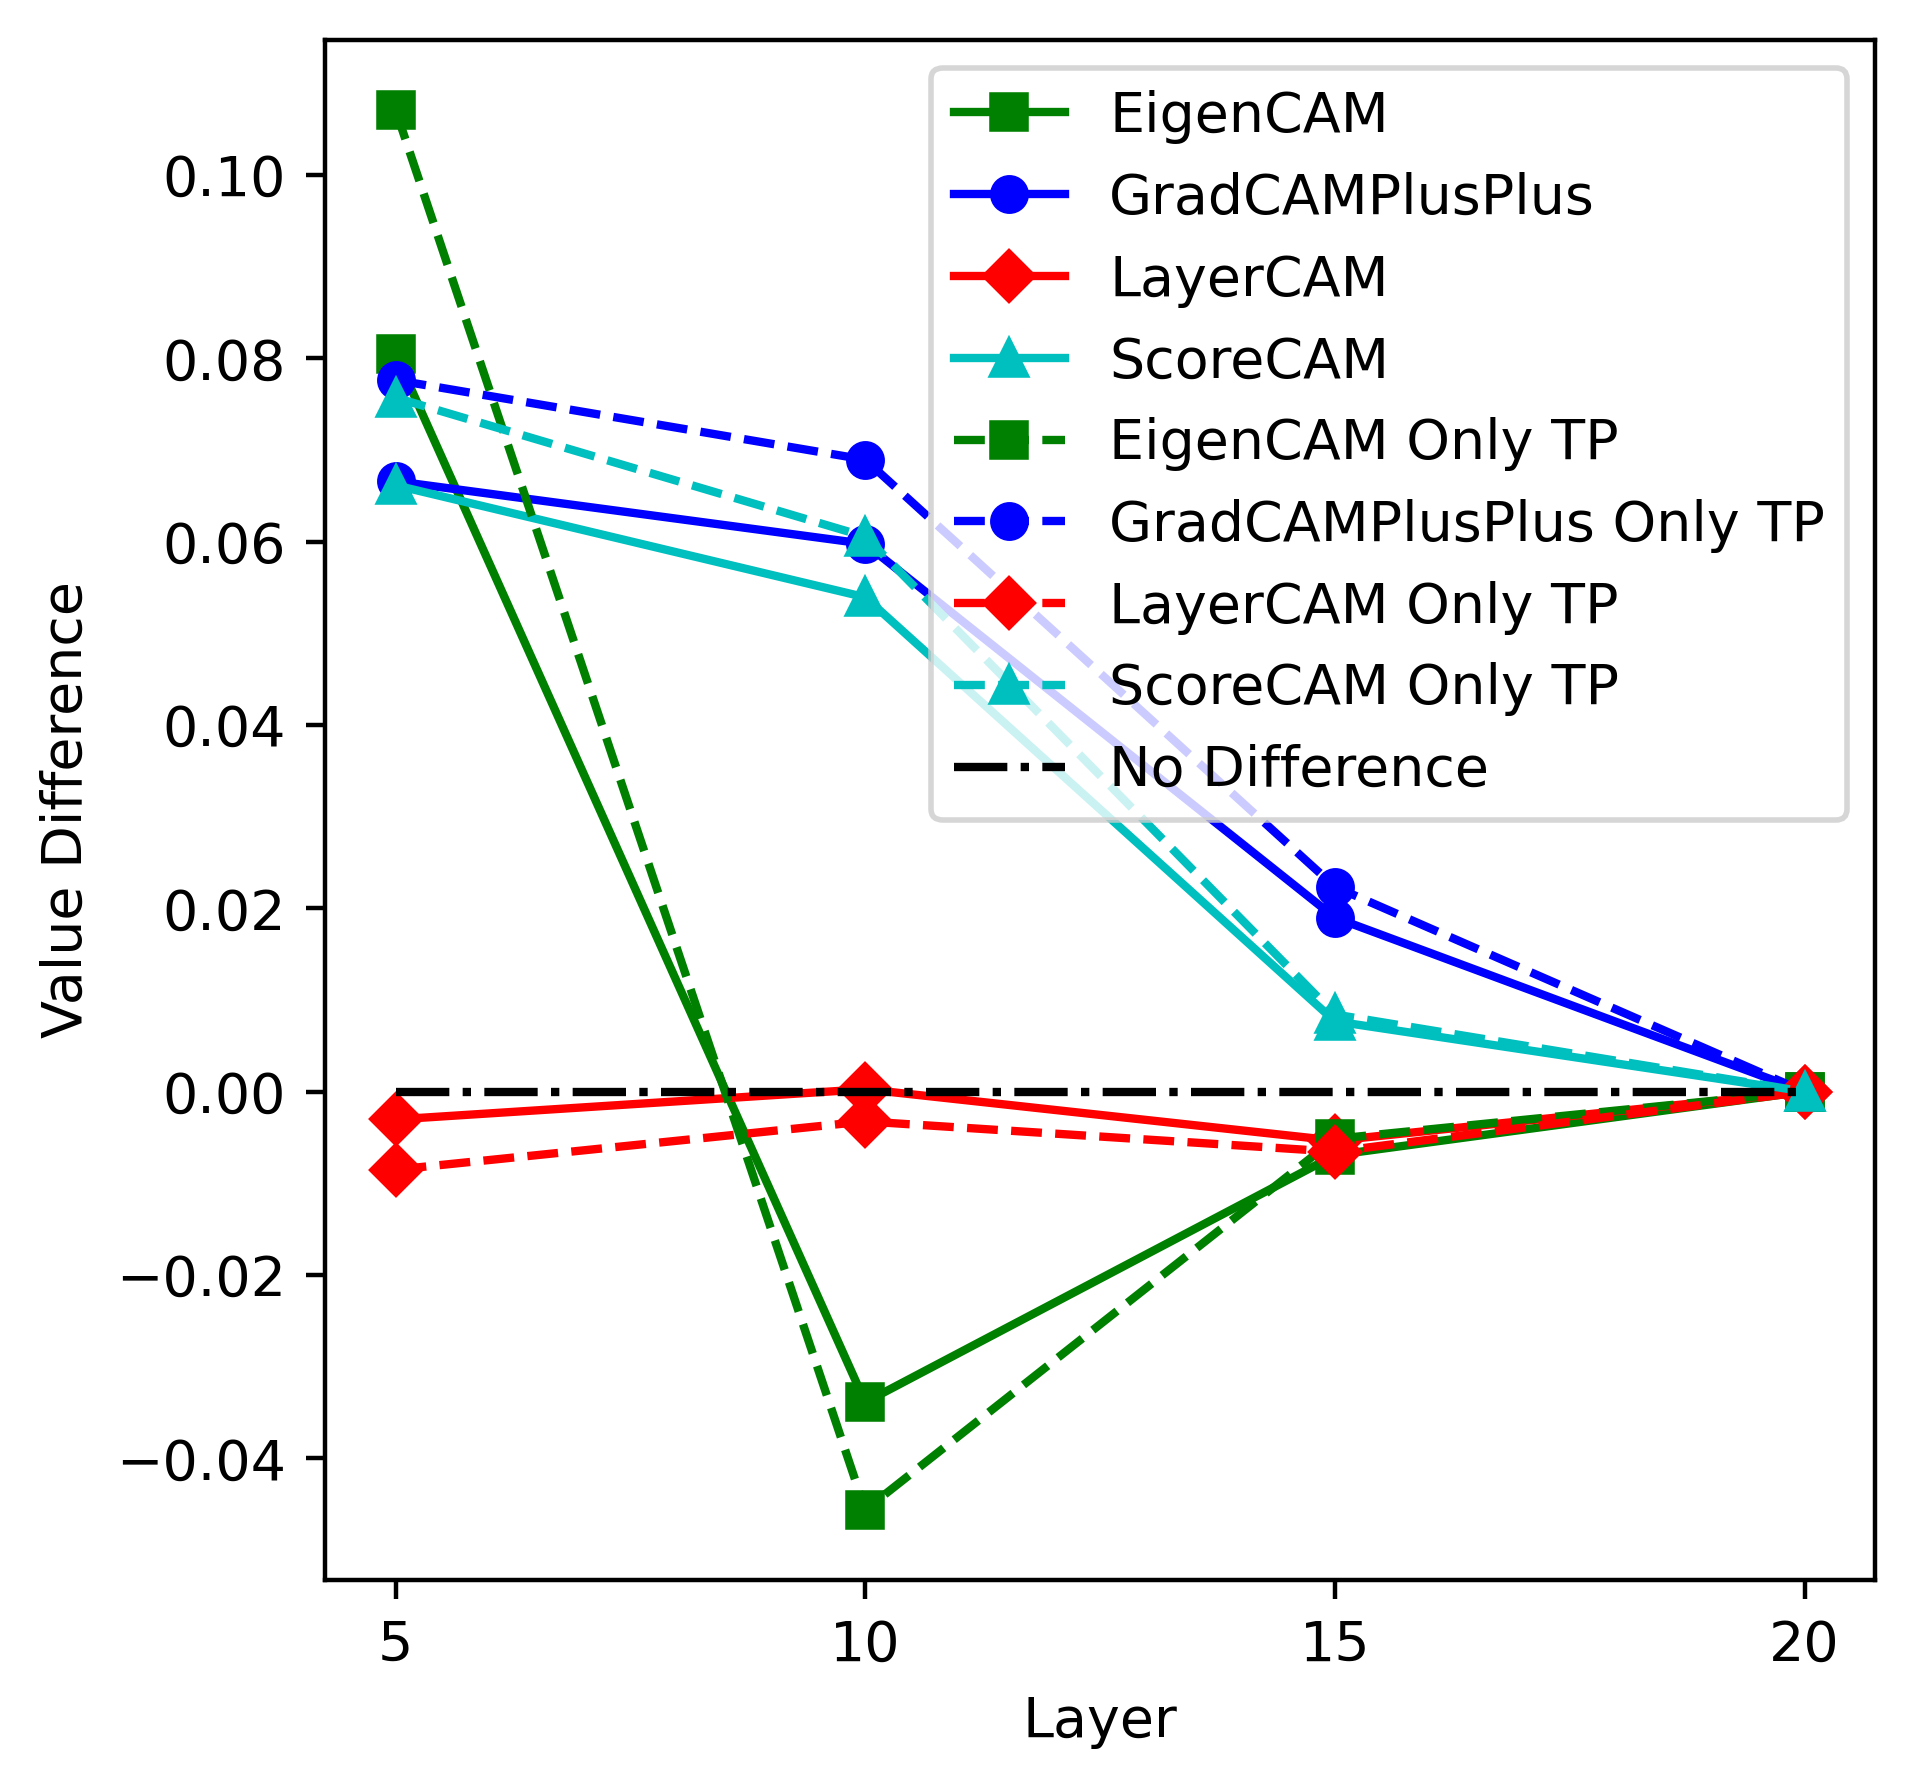

In [35]:
metrics = ["road_combined"]

def calculate_difference(group):
    if len(group) == 2:
        # Assuming there are exactly two rows in each group with different 'Mixing Method'
        diff = group['Value'].diff().iloc[1]
        return pd.Series([diff], index=['Value Difference'])
    else:
        return pd.Series([None], index=['Value Difference'])
    
marker_for_method = {
    "GradCAMPlusPlus": "o",
    "EigenCAM": "s",
    "LayerCAM": "D",
    "ScoreCAM": "^"}

color_for_method = {
    "GradCAMPlusPlus": "b",
    "EigenCAM": "g",
    "LayerCAM": "r",
    "ScoreCAM": "c"}

df_correct = df[df["Predicted Label"] == df["Label"]]
    
df_linestyles = ["-", "--"]

plt.figure(figsize=(5,5), dpi=400)

for df_index, d in enumerate([df, df_correct]):
    for metric in metrics:
        metric_df = d[d["Metric"] == metric]    
        grouped = metric_df.groupby([col for col in metric_df.columns if col not in ['Mixing Method', 'Value']]).apply(calculate_difference).reset_index()
        values = grouped.groupby(["Attribution Method", "Layer", "Upscale Method"]).agg({"Value Difference": ["mean","std", "count"]}).reset_index()
        # display(values)

        for method in methods:
            for upscale in upscale_methods[:1]:
                filtered_values = values[(values["Attribution Method"] == method) & (values["Upscale Method"] == upscale)]

                filtered_values["Layer"] = filtered_values["Layer"].apply(lambda x: int(x.split(".")[-1]))
                filtered_values = filtered_values.sort_values(by="Layer")
                plt.plot(filtered_values["Layer"],
                         filtered_values['Value Difference']['mean'],
                         marker=marker_for_method[method],
                         label=method + (" Only TP" if df_index == 1 else ""),
                         linestyle=df_linestyles[df_index],
                         color=color_for_method[method])
                
                plt.xticks([5,10,15,20])
                plt.xlabel("Layer")
                plt.ylabel("Value Difference")
                # display(filtered_values)

plt.plot([5,10,15,20], [0,0,0,0], linestyle="dashdot", color="black", label="No Difference")
plt.legend()